## Library

In [1]:
import sys
sys.path.append("../../")

In [2]:
SAVE_PATH = "../storage/demo/cnp_TFM_regression.ckpt"

In [3]:
import numpy as np               
import pandas as pd
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm     # Dynamic progress bars
import glob               # Lets us check if checkpoint files exist
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
tf.logging.set_verbosity(tf.logging.ERROR)  # Suppress depreciation warnings
tf.__version__

'1.15.0'

In [5]:
from neuralprocesses.np.aux import DataProvider
from neuralprocesses.utils.tf_utils import tf_sort_by_col
from neuralprocesses.utils.gp import GaussianProcess
from neuralprocesses.utils.gp import squared_exponential_kernel

from neuralprocesses.np.cnp import ConditionalNeuralProcess

from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color

In [6]:
tf.reset_default_graph()
tf.set_random_seed(2019)
tf.disable_eager_execution()

## Data

In [7]:
data = pd.read_csv('^DJI.csv', sep=",")
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index(['Date'])
data['X'] = np.arange(len(data))
data

,Open,High,Low,Close,Adj Close,Volume,X
Date,,,,,,,
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000,0
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1
1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,2
1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,3
1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000,4
...,...,...,...,...,...,...,...
2020-02-21,29146.529297,29146.529297,28892.699219,28992.410156,28992.410156,311210000,8837
2020-02-24,28402.929688,28402.929688,27912.439453,27960.800781,27960.800781,452580000,8838
2020-02-25,28037.650391,28149.199219,26997.619141,27081.359375,27081.359375,513270000,8839


## Data Preprocessing

In [8]:
data_train = pd.DataFrame(data[['Close','X']].values, columns=['T','X']).loc[:2000]
data_test_1 = pd.DataFrame(data[['Close','X']].values, columns=['T','X']).loc[2000:4000]

for s in range(1,2):
    data_train['Y'.format(s)] = data_train['T'].shift(s)
    data_test_1['Y'.format(s)] = data_test_1['T'].shift(s)

data_train = data_train.dropna()
data_test_1 = data_test_1.dropna()
X_train = data_train.drop(['X','T'], axis=1)
y_train = data_train.drop(['X','Y'], axis=1)
X_test_1 = data_test_1.drop(['X','T'], axis=1)
y_test_1 = data_test_1.drop(['X','Y'], axis=1)


print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test 1 size: (%d x %d)'%(y_test_1.shape[0], y_test_1.shape[1]))

Train size: (2000 x 1)
Test 1 size: (2000 x 1)


## RNN Model

In [9]:
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                            inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)

from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Input, Dense, LSTM
from tensorflow.python.keras.models import Sequential

tf.keras.backend.clear_session()

nn = Sequential()
nn.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
nn.add(Dense(5,input_shape=(X_train.shape[1],), activation="relu"))
nn.add(Dense(5,input_shape=(X_train.shape[1],), activation="relu"))
nn.add(Dense(1))

adam = Adam(lr=0.1, beta_1=0.92, beta_2=0.999, decay=0.0, amsgrad=False)
nn.compile(optimizer=adam, loss='mean_absolute_error')
nn.summary()
history_nn = nn.fit(x=X_train, y=y_train, batch_size=16, epochs=17, verbose=1, callbacks=None)
y_pred_nn_1 = nn.predict(X_test_1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples
Epoch 1/17
2000/2000 [==============================] - 0s 124us/sample - loss: 219.9618
Epoch 2/17
2000/2000 [==============================] - 0s 48us/sample - loss: 77.7627
Epoch 3/17
2000/2000 [==============================] - 0s

## CNP DATA

In [10]:
def target_split(data, interval):
    target_index_list = list([True if (i+1)%interval==0 else False for i in list(np.arange(0, data.shape[0], 1))])
    context_index_list = list([False if (i+1)%interval==0 else True for i in list(np.arange(0, data.shape[0], 1))])
    target = data.loc[target_index_list]
    context = data.loc[context_index_list]
    return context, target

In [11]:
BATCH_SIZE = 1
plotting_mode = tf.placeholder(dtype=tf.bool, name="plotting_mode")
interval_num = 2
context_cnp, target_cnp = target_split(data_train,interval_num)
context_test_1, target_test_1 = target_split(data_test_1,interval_num)

# Choose the number of context points
num_context_points = tf.random_uniform(
    shape=(),
    minval=tf.dtypes.saturate_cast(context_cnp.shape[0]/BATCH_SIZE, tf.int32, name=None),
    maxval=tf.dtypes.saturate_cast(context_cnp.shape[0]/BATCH_SIZE+1, tf.int32, name=None),
    dtype=tf.int32
)

# Choose the number of target points
num_target_points = tf.random_uniform(
    shape=(),
    minval=tf.dtypes.saturate_cast(target_cnp.shape[0]/BATCH_SIZE, tf.int32, name=None),
    maxval=tf.dtypes.saturate_cast(target_cnp.shape[0]/BATCH_SIZE+1, tf.int32, name=None),
    dtype=tf.int32
)

In [12]:
# Train
x_context = tf.dtypes.saturate_cast(tf.reshape(context_cnp['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context = tf.dtypes.saturate_cast(tf.reshape(context_cnp['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target = tf.dtypes.saturate_cast(tf.reshape(target_cnp['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target = tf.dtypes.saturate_cast(tf.reshape(target_cnp['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 1
x_context_test = tf.dtypes.saturate_cast(tf.reshape(context_test_1['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test = tf.dtypes.saturate_cast(tf.reshape(context_test_1['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test = tf.dtypes.saturate_cast(tf.reshape(target_test_1['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test = tf.dtypes.saturate_cast(tf.reshape(target_test_1['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

In [13]:
import collections
RegressionInput = collections.namedtuple(
    "RegressionInput",
    ("queries", "targets", "num_context", "num_target"))
data = RegressionInput(queries=((x_context, y_context), x_target), targets=y_target, num_context=num_context_points, num_target=num_target_points)

## GP Model

In [14]:
#kernel = lambda x: squared_exponential_kernel(x, 2.0)
gp_model = GaussianProcess(squared_exponential_kernel, name="gp-model")

In [15]:
_, gp_mean, gp_variance, _ = gp_model(((x_context, y_context), x_target))

In [16]:
with tf.variable_scope("gp_plot"):
    gp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    gp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0]], axis=1), 0)
    gp_plot_max = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] + tf.sqrt(gp_variance[0])], axis=1), 0)
    gp_plot_min = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] - tf.sqrt(gp_variance[0])], axis=1), 0)

## CNP Model

In [17]:
cnp = ConditionalNeuralProcess(name="cnp-model")

In [18]:
cnp_mean, cnp_variance, cnp_loss = cnp(data)

In [19]:
with tf.variable_scope("cnp_trainer"):
    optimizer = tf.train.AdamOptimizer()
    training_step = optimizer.minimize(cnp_loss)

In [20]:
with tf.variable_scope("cnp_plot"):
    cnp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    cnp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0]], axis=1), 0)
    cnp_plot_max = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] + tf.sqrt(cnp_variance[0])], axis=1), 0)
    cnp_plot_min = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] - tf.sqrt(cnp_variance[0])], axis=1), 0)

### Training

In [21]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [22]:
NUM_EPISODES = 1000
SAVE_STEP = 1000

with tf.Session() as session:
   
    # Initialize variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver( 
        max_to_keep=4, 
        keep_checkpoint_every_n_hours=1
    )
    session.run(init)

    # Do training
    for episode in tqdm(range(NUM_EPISODES)):
        session.run(training_step, feed_dict={plotting_mode: False})

        if episode % SAVE_STEP == 0 or episode == NUM_EPISODES - 1:
            saver.save(session, SAVE_PATH, global_step=episode)

    # Save resulting graph
    print(f"Model saved in: {saver.save(session, SAVE_PATH)}")

100%|██████████| 1000/1000 [00:11<00:00, 90.16it/s]


Model saved in: ../storage/demo/cnp_TFM_regression.ckpt


## Prediction

In [23]:
def gp_predict(xc, yc, xt, ground_truth_data):
    with tf.Session() as session:        
        #xt = list(yt.index)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [gp_plot_context, gp_plot_mean, gp_plot_max, gp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )
        # Plot the result
        list_plot([xy, xymin, xymax, ctxt, ground_truth_data],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300},
                  # Ground truth in black
                  Color((0,0,0))
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )
        return xy

In [24]:
def cnp_predict(xc, yc, xt, ground_truth_data):
    with tf.Session() as session:
        saver.restore(session, SAVE_PATH)
        
        #xt = list(yt.index)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [cnp_plot_context, cnp_plot_mean, cnp_plot_max, cnp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )
        # Plot the result
        list_plot([xy, xymin, xymax, ctxt, ground_truth_data],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300},
                  # Ground truth in black
                  Color((0,0,0))
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )
        return xy

# Result

### - RNN

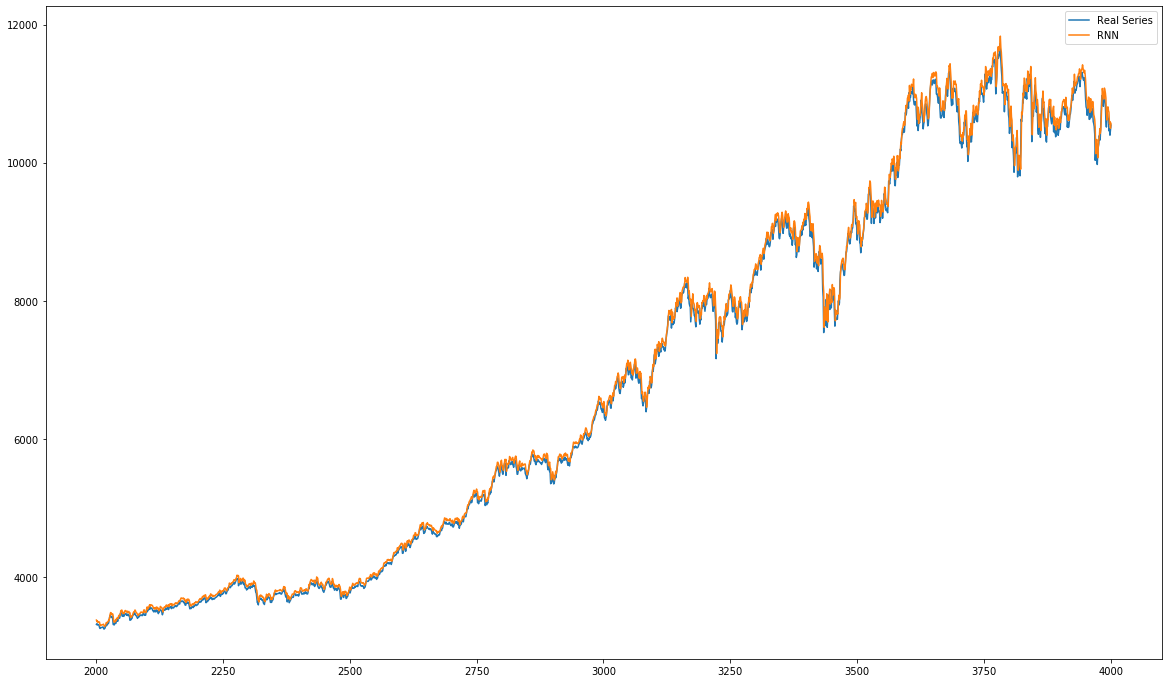

MSE RNN P1:   78.05


In [25]:
y_pred_nn_1=pd.DataFrame(y_pred_nn_1, index=y_test_1.index)
plt.figure(figsize=(20,12))
plt.plot(pd.concat([y_test_1]), label='Real Series')
plt.plot(pd.concat([y_pred_nn_1]), label='RNN')
plt.legend()
plt.show()
print("MSE RNN P1: {0:7.2f}".format((np.absolute(y_test_1 - y_pred_nn_1.values)).values.mean()))

### - GP

In [26]:
with tf.Session() as session:
    xc, yc, xt, yt = session.run([
        x_context_test[0], y_context_test[0], x_target_test[0], y_target_test[0]], feed_dict={plotting_mode: True})

#### Part 1

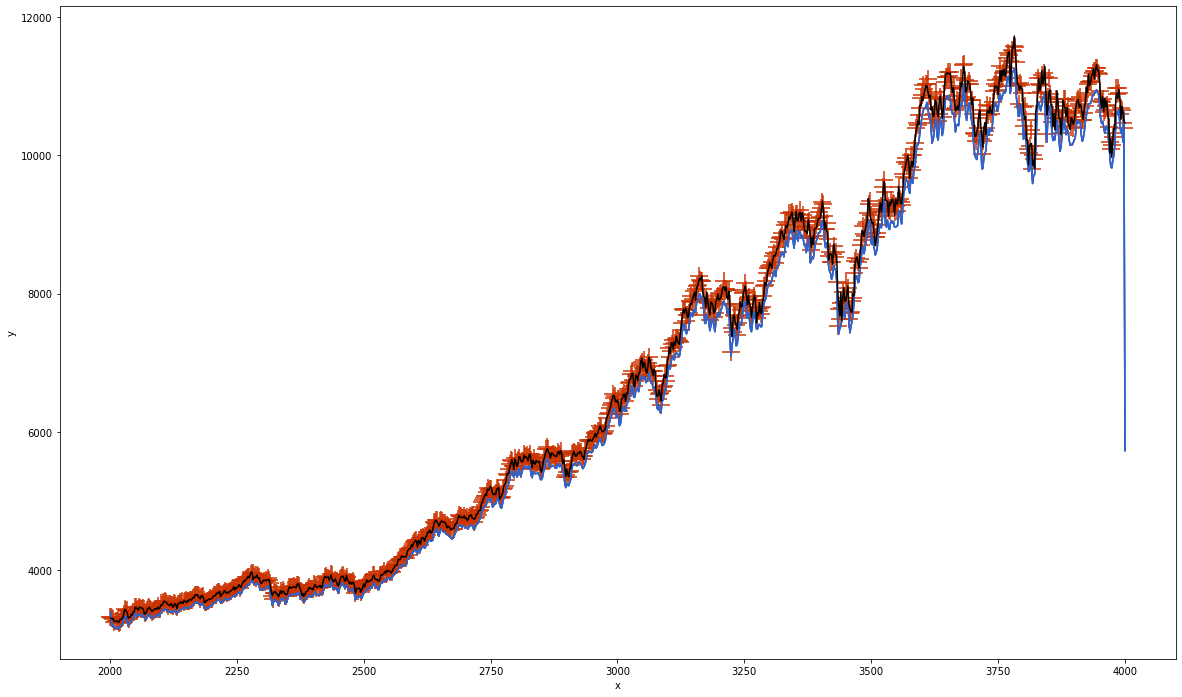

MSE GP:  198.68


In [27]:
plt.figure(figsize=(20,12))
pred_gp = gp_predict(xc, yc, xt, np.transpose([xt, yt]))
print("MSE GP: {0:7.2f}".format((np.absolute(yt - pred_gp[:,1])).mean()))

### - CNP
#### Part 1

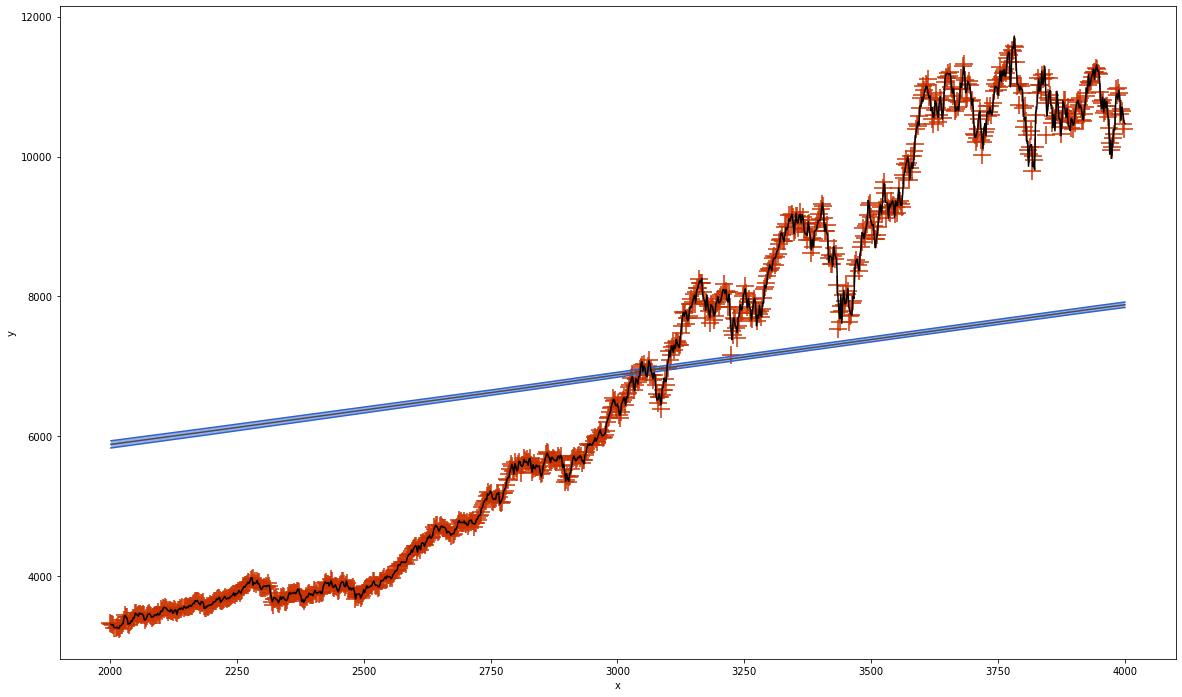

MSE CNP: 1961.12


In [28]:
plt.figure(figsize=(20,12))
pred_cnp = cnp_predict(xc, yc, xt, np.transpose([xt, yt]))
print("MSE CNP: {0:7.2f}".format((np.absolute(yt - pred_cnp[:,1])).mean()))

In [29]:
pred_cnp[:,1]

array([5884.6553, 5886.578 , 5888.501 , 5890.424 , 5892.3467, 5894.27  ,
       5896.192 , 5898.1157, 5900.0386, 5901.962 , 5903.884 , 5905.8066,
       5907.7305, 5909.655 , 5911.5767, 5913.4995, 5915.4224, 5917.3457,
       5919.2686, 5921.191 , 5923.113 , 5925.0366, 5926.9595, 5928.883 ,
       5930.805 , 5932.7285, 5934.652 , 5936.575 , 5938.4966, 5940.42  ,
       5942.343 , 5944.266 , 5946.1885, 5948.1123, 5950.0347, 5951.9575,
       5953.881 , 5955.8037, 5957.727 , 5959.65  , 5961.5728, 5963.495 ,
       5965.4175, 5967.341 , 5969.265 , 5971.1865, 5973.109 , 5975.0327,
       5976.955 , 5978.879 , 5980.802 , 5982.7256, 5984.6475, 5986.5713,
       5988.494 , 5990.4165, 5992.3394, 5994.263 , 5996.1855, 5998.1074,
       6000.0312, 6001.9546, 6003.877 , 6005.8003, 6007.723 , 6009.6465,
       6011.5684, 6013.492 , 6015.414 , 6017.338 , 6019.2607, 6021.1836,
       6023.1064, 6025.0303, 6026.9526, 6028.875 , 6030.846 , 6032.832 ,
       6034.8164, 6036.8037, 6038.7886, 6040.7754, 